In [1]:
import nltk
import jieba
import numpy as np
import keras
from keras import Sequential, utils
from keras.layers import Activation, Dense
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 根据停用词，词频等过滤word_set
def filter_word_set(word_set):
    return word_set

# 生成word2index
def gene_word2index(filename):
    word_set = set()
    with open(filename, "r", encoding='utf-8') as f:
        for line in f:
            sentence = jieba.lcut(line.strip())
            for w in sentence:
                word_set.add(w)
    word_set = filter_word_set(word_set)
    
    word2index = dict()
    for i, w in zip(range(len(word_set)), word_set):
        word2index[w] = i
    return word2index


# 把word2index 变成onehot形式，这里不用
def word_index2onehot(word2index):
    word2onehot = dict()
    for word, index in word2index.items():
        onehot_list = np.zeros(len(word2index))
        onehot_list[index] = 1
        word2onehot[word] = onehot_list
    return word2onehot

# 把（n1,n2,n3,n4）变成onehot并求和[1,1,1,1,0,0...] n是onehot的维数
def trans_onehot(li, dim):
    onehot_list = np.zeros([dim])
    for i in li:
        onehot_list[i] = 1
    return onehot_list

# 创建训练集 加权后的onehot形式
def create_train_data(filename, word2index, n=5):
    if n % 2 != 1 or n < 3:
        raise Exception("n must be odd and n>=3")
        
    sentence_index_list = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            sentence = jieba.lcut(line.strip())
            word_index = [word2index[w] for w in sentence if w in word2index]
            sentence_index_list.append(word_index)
            
    x_y_list = []
    split = n // 2
    for s in sentence_index_list:
        tuple_list = list(nltk.ngrams(s, n))
        for tup in tuple_list:
            x, y = [], []
            for i in range(n):
                if i == split:
                    y.append(tup[i])
                else:
                    x.append(tup[i])
            x_y_list.append((x, y))
    
    np.random.shuffle(x_y_list)
    X, Y = [], []
    for item in x_y_list:
        x = trans_onehot(item[0], len(word2index))
        X.append(x)
        y = trans_onehot(item[1], len(word2index))
        Y.append(y)
    
    return X, Y

# 创建模型
def creat_model(x_train, y_train, embedding_dim=100):
    model = Sequential()
    model.add(Dense(embedding_dim, input_dim=x_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(y_train.shape[1]))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
filename = './data/names_of_people.txt'

In [4]:
word2index = gene_word2index(filename)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.925 seconds.
Prefix dict has been built succesfully.


In [5]:
X, y = create_train_data(filename, word2index)

In [6]:
X_train = np.array(X)
y_train = np.array(y)

In [7]:
X_train.shape

(13235, 3760)

In [8]:
type(X_train)

numpy.ndarray

In [9]:
y_train.shape

(13235, 3760)

## 模型训练

In [10]:
epochs = 20
batch_size = 128
model = creat_model(X_train, y_train)

In [11]:
history = model.fit(X_train, y_train, validation_split=0.3, verbose=1, batch_size=batch_size, epochs=epochs)

Train on 9264 samples, validate on 3971 samples
Epoch 1/20
9264/9264 [==============================] - 6s 635us/step - loss: 7.9684 - acc: 0.0806 - val_loss: 7.3440 - val_acc: 0.1005
Epoch 2/20
9264/9264 [==============================] - 2s 226us/step - loss: 6.7239 - acc: 0.0978 - val_loss: 7.0936 - val_acc: 0.1005
Epoch 3/20
9264/9264 [==============================] - 2s 228us/step - loss: 6.4184 - acc: 0.0978 - val_loss: 7.1260 - val_acc: 0.1005
Epoch 4/20
9264/9264 [==============================] - 2s 228us/step - loss: 6.2845 - acc: 0.0978 - val_loss: 7.1650 - val_acc: 0.1005
Epoch 5/20
9264/9264 [==============================] - 2s 229us/step - loss: 6.1795 - acc: 0.0978 - val_loss: 7.1951 - val_acc: 0.1005
Epoch 6/20
9264/9264 [==============================] - 2s 232us/step - loss: 6.0782 - acc: 0.0979 - val_loss: 7.2275 - val_acc: 0.1015
Epoch 7/20
9264/9264 [==============================] - 2s 232us/step - loss: 5.9701 - acc: 0.0995 - val_loss: 7.2794 - val_acc: 0.1073


## 画图

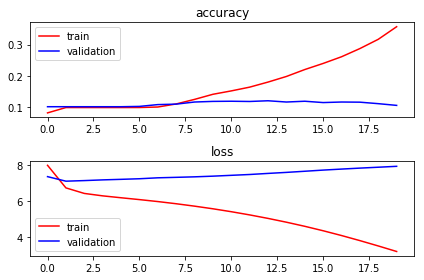

In [12]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()